# Main Notebook

### Required packages

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from torchvision import transforms
import numpy as np

## Utils Functions

In [45]:
import matplotlib.pyplot as plt

def show_images(dataset, n_samples=20, n_cols=4):
    """
    Plots n_samples from dataset with n_cols columns.
    
    Receives:
    - dataset: Dataset with image samples (assuming each sample can be accessed and is a PIL image or a numpy array)
    - n_samples: Number of samples to display
    - n_cols: Number of columns in the figure 
    """
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):  # Use dataset, not data
        if i == n_samples:  # Correct variable name
            break
        n_rows = n_samples // n_cols + (1 if n_samples % n_cols != 0 else 0)  # Calculate the number of rows correctly
        plt.subplot(n_rows, n_cols, i+1)
        if isinstance(img, tuple) or isinstance(img, list):
            plt.imshow(img[0])  # Assuming the image is the first element in a tuple/list
        else:
            plt.imshow(img)  # Directly use img if it's the image itself
        plt.axis('off')  # Turn off the axis
    plt.show()  # Display the figure


In [46]:
class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform = None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image[None]

## Get the Data

In [47]:
data = torchvision.datasets.StanfordCars(root="../data/", download=True)

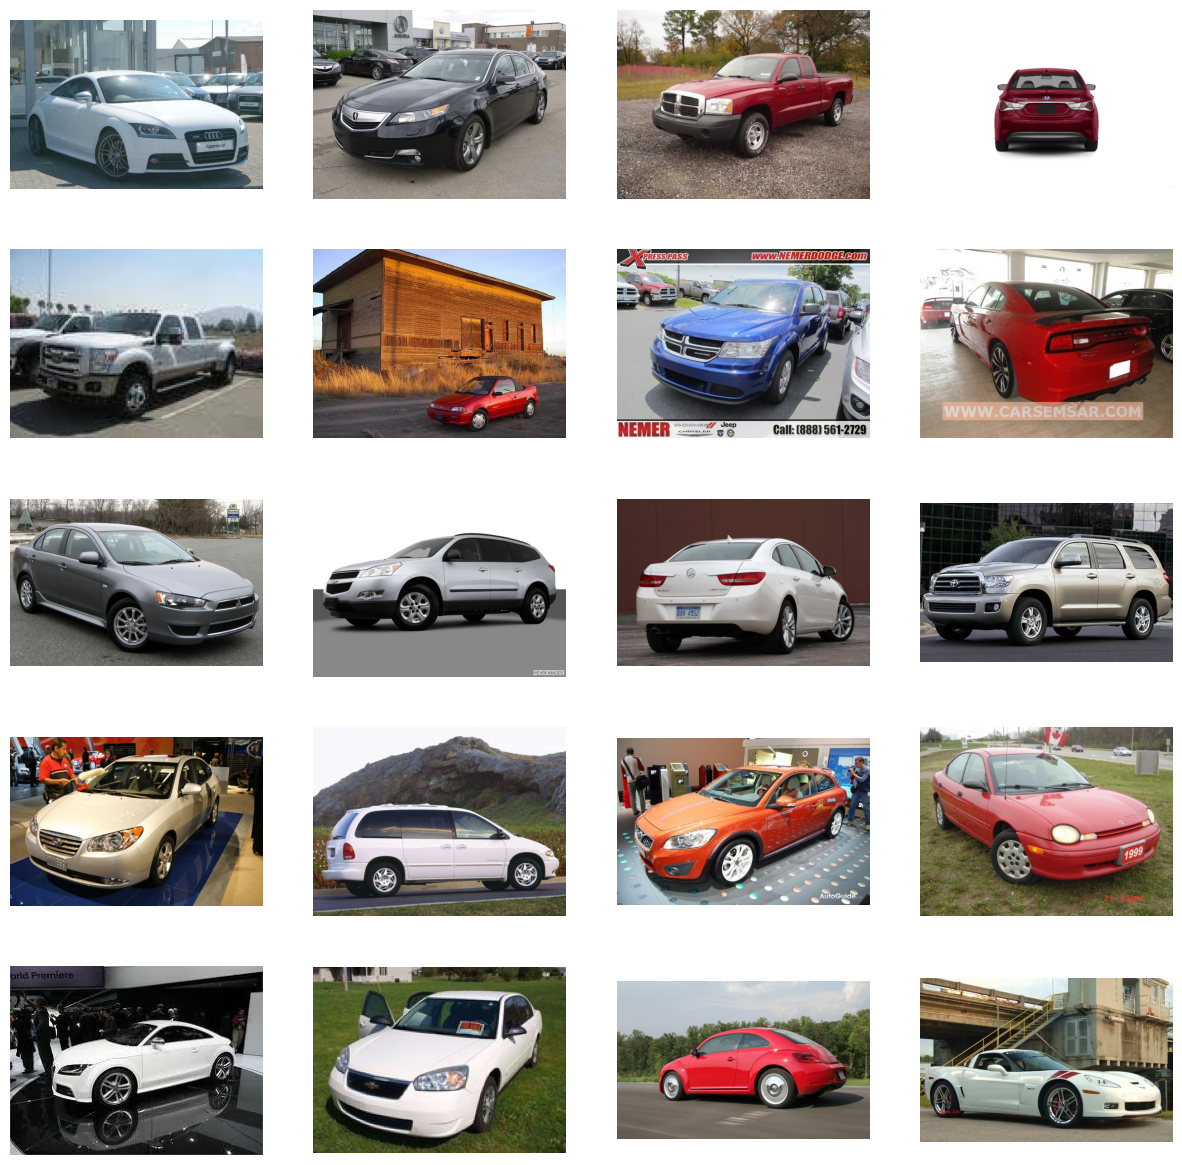

In [48]:
show_images(data)

## Building the Diffusion Model

## Step 1: The forward process = Noise scheduler

Durante este paso, se añade ruido gradualmente a las imágenes originales o datos a lo largo de varios timesteps. Este proceso transforma los datos desde su estado original hasta un estado de puro ruido, siguiendo una trayectoria predeterminada.

La fórmula general utilizada para simular el proceso de difusión hacia adelante en modelos de difusión, específicamente para añadir ruido a una imagen, se basa en la siguiente ecuación:


$$
x_t = \sqrt{\alpha_t} \cdot x_0 + \sqrt{1 - \alpha_t} \cdot \epsilon
$$

Donde:

- $x_t$ es la imagen ruidosa en el tiempo $t$.
- $x_0$ es la imagen original (sin ruido) al inicio del proceso.
- $\alpha_t$ es un coeficiente que decrece con el tiempo $t$ y representa la proporción de la imagen original que se mantiene en $x_t$.
- $\epsilon$ representa el ruido aleatorio añadido a la imagen, típicamente muestreado de una distribución normal estándar (por ejemplo, $\mathcal{N}(0, I)$), donde $I$ es la matriz de identidad.
- $1 - \alpha_t$ representa la proporción del ruido en la imagen ruidosa $x_t$.

La ecuación muestra cómo, en cada paso de tiempo $t$, la imagen $x_t$ se compone de dos partes: una fracción de la imagen original $x_0$ y una fracción del ruido $\epsilon$. El coeficiente $\sqrt{\alpha_t}$ controla cuánto de la imagen original se preserva, mientras que $\sqrt{1 - \alpha_t}$ controla cuánto ruido se añade. A medida que $t$ aumenta (y $\alpha_t$ disminuye), la proporción de ruido en $x_t$ aumenta, y la imagen se va alejando de su estado original hacia un estado más ruidoso.

Este proceso de añadir ruido es determinista, dado que $\alpha_t$ se define de antemano y el ruido $\epsilon$ se genera de manera controlada. El objetivo de este proceso en el contexto de los modelos de difusión es aprender la transición gradual de datos limpios a datos completamente ruidosos, de manera que el modelo pueda, eventualmente, aprender a invertir este proceso para generar nuevas muestras a partir de ruido puro.




In [49]:
import torch.nn.functional as F

def linear_beta_scheduler(timesteps, start=0.001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Retruns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device='cpu'):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    
    noise = torch.rand_lix(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphnas_cumprod, t, x_.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)